# Customer Life Time Value Prediction (LTV)

In [679]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time

from datetime import date
from sklearn.cluster import KMeans
from dataprep.eda import plot_missing
from functools import wraps
from sklearn.manifold import TSNE
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('husl')

In [590]:
Blue = '#4285FA'
Red = '#EA4335'
Yellow = '#FBBC05'
Green = '#34A853'

In [2]:
df = pd.read_excel('OnlineRetail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Transform columns to lowercase for easy coding
df.columns = df.columns.str.lower()

# Subset UK customer only
df = df[df.country == 'United Kingdom'].reset_index(drop=True)

# Transform invoicedate to time series
df['invoicedate'] = pd.to_datetime(df.invoicedate)

## 1. EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    495478 non-null  object        
 1   stockcode    495478 non-null  object        
 2   description  494024 non-null  object        
 3   quantity     495478 non-null  int64         
 4   invoicedate  495478 non-null  datetime64[ns]
 5   unitprice    495478 non-null  float64       
 6   customerid   361878 non-null  float64       
 7   country      495478 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 30.2+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,495478.0,8.605486,227.588756,-80995.00,1.00,3.0,10.00,80995.0
unitprice,495478.0,4.532422,99.315438,-11062.06,1.25,2.1,4.13,38970.0
customerid,361878.0,15547.871368,1594.402590,12346.00,14194.00,15514.0,16931.00,18287.0


In [6]:
df.select_dtypes('object').describe().T

,count,unique,top,freq
invoiceno,495478,23494,573585,1114
stockcode,495478,4065,85123A,2215
description,494024,4202,WHITE HANGING HEART T-LIGHT HOLDER,2271
country,495478,1,United Kingdom,495478


In [7]:
df.invoicedate.describe()

count                  495478
unique                  21220
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:49:00
Name: invoicedate, dtype: object

In [8]:
df.isnull().sum()

invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     133600
country             0
dtype: int64

In [9]:
plot_missing(df)

customerid missing values has 0.09 correlation with description missing values. 

In [10]:
# Imputate Not Available for description. Also, customerid need clarification with other department
# in regard to customerid return missing value. We will impute 0 for now

df.loc[df.description.isnull(), 'description'] = 'Not Available'
df.loc[df.customerid.isnull(), 'customerid'] = 0

In [11]:
df.isnull().sum()

invoiceno      0
stockcode      0
description    0
quantity       0
invoicedate    0
unitprice      0
customerid     0
country        0
dtype: int64

In [12]:
df.dtypes

invoiceno              object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
unitprice             float64
customerid            float64
country                object
dtype: object

## 2. Customer Segmentation 
### a. Recency

In [13]:
# Create 2 dataframe of 3 months data and 6 months data
df_3m = df[(df.invoicedate >= '2011-3-1') & (df.invoicedate < '2011-6-1')].reset_index(drop=True)

df_6m = df[(df.invoicedate >= '2011-6-1') & (df.invoicedate < '2011-12-1')].reset_index(drop=True)

In [14]:
df_3m.invoicedate.describe()

count                   95193
unique                   4852
top       2011-04-18 13:13:00
freq                      333
first     2011-03-01 08:30:00
last      2011-05-31 15:53:00
Name: invoicedate, dtype: object

In [15]:
df_6m.invoicedate.describe()

count                  278966
unique                  11477
top       2011-10-31 14:41:00
freq                     1114
first     2011-06-01 07:37:00
last      2011-11-30 17:42:00
Name: invoicedate, dtype: object

In [16]:
# Create table with unique customer id of 3 months of data
df_user = pd.DataFrame(df_3m.customerid.unique()).rename(columns={0:'customerid'})
# Find recency of each customer
purchase = df_3m.groupby('customerid').invoicedate.max().reset_index()
purchase['recency'] = (purchase.invoicedate.max() - purchase.invoicedate).dt.days
# Map customer id to their recency
df_user = pd.merge(df_user, purchase[['customerid', 'recency']], on='customerid')
df_user.head(3)

,customerid,recency
0,14620.0,12
1,14740.0,4
2,13880.0,25


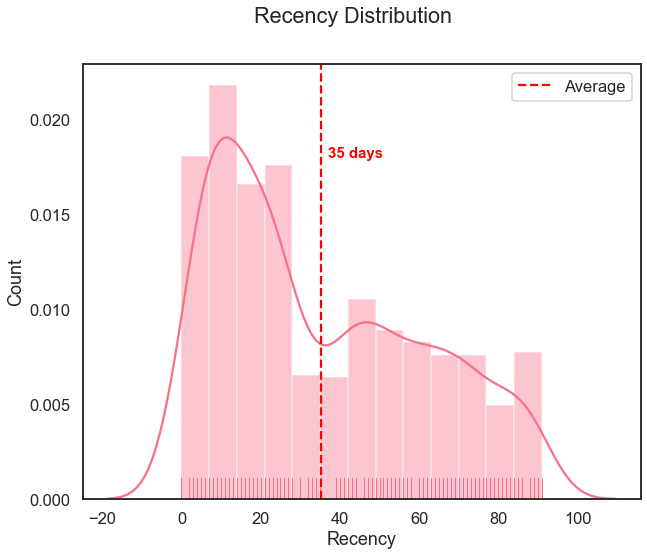

In [591]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_user.recency, rug=True)
ax.axvline(df_user.recency.mean(), linestyle='--', color='r', label='Average')
ax.set_xlabel('Recency'); ax.set_ylabel('Count'); fig.suptitle('Recency Distribution')
ax.text(37, 0.018, '35 days',size='small', color='r', weight='semibold')
ax.legend()


In [18]:
#Elbow Plot
def elbow_plot(feature):
    k_range = range(1,10)
    distance = []
    for k in k_range:
        km = KMeans(n_clusters=k, max_iter=1000).fit(feature)
        distance.append(km.inertia_)
    
    sns.set_style('whitegrid')
    sns.lineplot(k_range, distance, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distance')
    plt.show()

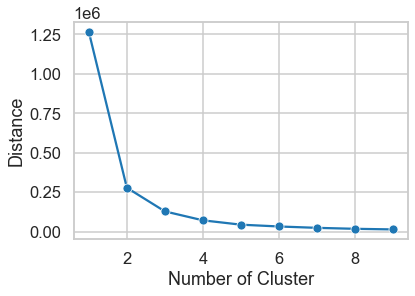

In [19]:
elbow_plot(df_user[['recency']])

In [20]:
kmeans = KMeans(n_clusters=4).fit(df_user[['recency']])
df_user['r_cluster'] = kmeans.predict(df_user[['recency']])

In [21]:
#Checking recency cluster before cluster transformation
df_user.groupby('r_cluster').recency.describe()

,count,mean,std,min,25%,50%,75%,max
r_cluster,,,,,,,,
0,439.0,50.050114,7.370325,39.0,43.0,49.0,56.0,63.0
1,609.0,8.333333,4.415011,0.0,5.0,8.0,12.0,16.0
2,349.0,76.919771,8.356936,64.0,70.0,76.0,84.0,91.0
3,444.0,24.403153,4.953243,17.0,20.0,23.0,27.0,35.0


We want to re-order the clusters so that cluster 3 = lower recency and cluster 0 = high recency. We want it to be an ordinal categorical feature. 

In [22]:
df_new = df_user.groupby('r_cluster').recency.mean().reset_index()
df_new

,r_cluster,recency
0,0,50.050114
1,1,8.333333
2,2,76.919771
3,3,24.403153


In [23]:
df_new = df_new.sort_values('recency', ascending=False).reset_index(drop=True)
df_new

,r_cluster,recency
0,2,76.919771
1,0,50.050114
2,3,24.403153
3,1,8.333333


The index 3 = 8.3 recency(low) and index 0 = 7.6 recency(high). We can manipulate this index so it become the new cluster label

In [24]:
df_new['index'] = df_new.index
df_new

,r_cluster,recency,index
0,2,76.919771,0
1,0,50.050114,1
2,3,24.403153,2
3,1,8.333333,3


In [25]:
df_user = pd.merge(df_user, df_new[['r_cluster', 'index']], on='r_cluster')
df_user.drop('r_cluster', axis=1, inplace=True)
df_user.rename(columns={'index': 'r_cluster'}, inplace=True)

In [26]:
#Checking recency cluster after cluster transformation
df_user.groupby('r_cluster').recency.describe()

,count,mean,std,min,25%,50%,75%,max
r_cluster,,,,,,,,
0,349.0,76.919771,8.356936,64.0,70.0,76.0,84.0,91.0
1,439.0,50.050114,7.370325,39.0,43.0,49.0,56.0,63.0
2,444.0,24.403153,4.953243,17.0,20.0,23.0,27.0,35.0
3,609.0,8.333333,4.415011,0.0,5.0,8.0,12.0,16.0


We have higher number of cluster as our most favourable recency

In [27]:
df_user.head(3)

,customerid,recency,r_cluster
0,14620.0,12,3
1,14740.0,4,3
2,17068.0,11,3


In [28]:
df_user.dtypes

customerid    float64
recency         int64
r_cluster       int64
dtype: object

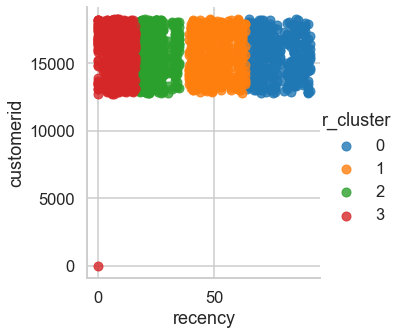

In [29]:
sns.lmplot(x='recency',y='customerid', hue='r_cluster', data=df_user, fit_reg=False )

In [30]:
# Define function for cluster ordering
def cluster_order(cluster_name, target_name, df, ascending):
    df_n = df.groupby(cluster_name)[target_name].mean().reset_index()
    df_n = df_n.sort_values(target_name, ascending=ascending).reset_index(drop=True)
    df_n['index'] = df_n.index
    df_final = pd.merge(df, df_n[[cluster_name, 'index']], on=cluster_name)
    df_final.drop(cluster_name, axis=1, inplace=True)
    df_final.rename(columns={'index': cluster_name}, inplace=True)
    return df_final

### b. Frequency

In [31]:
frequency = df_3m.groupby('customerid').invoicedate.count().reset_index()
frequency.rename(columns={'invoicedate': 'frequency'}, inplace=True)

In [32]:
frequency.head(3)

,customerid,frequency
0,0.0,23510
1,12747.0,35
2,12748.0,582


In [33]:
df_user = pd.merge(df_user, frequency, on='customerid')
df_user.head(3)

,customerid,recency,r_cluster,frequency
0,14620.0,12,3,30
1,14740.0,4,3,89
2,17068.0,11,3,76


In [34]:
df_user.frequency.describe()

count     1841.000000
mean        51.707224
std        550.408209
min          1.000000
25%         12.000000
50%         23.000000
75%         47.000000
max      23510.000000
Name: frequency, dtype: float64

In [35]:
df_user.shape

(1841, 4)

In [36]:
len(df_user[df_user.customerid == 0])

1

In [37]:
df_user = df_user[df_user.customerid != 0]
df_user.shape

(1840, 4)

In [38]:
df_user.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,1840.0,15534.587500,1577.266588,12747.0,14197.25,15554.5,16841.5,18287.0
recency,1840.0,35.177717,26.229224,0.0,12.00,26.0,56.0,91.0
r_cluster,1840.0,1.712500,1.116126,0.0,1.00,2.0,3.0,3.0
frequency,1840.0,38.958152,60.968929,1.0,12.00,23.0,47.0,1364.0


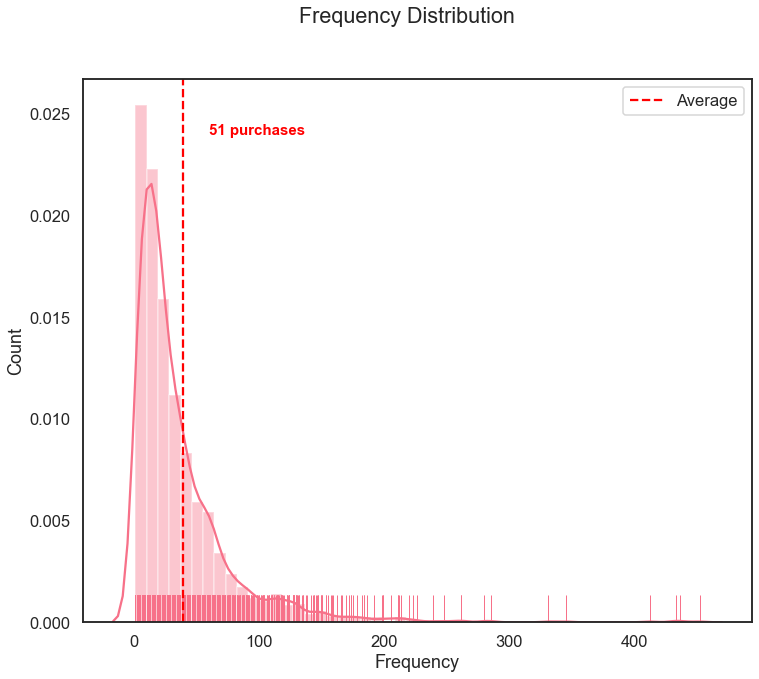

In [592]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,10))
sns.distplot(df_user.query('frequency <500')['frequency'], rug=True)
ax.axvline(df_user.frequency.mean(), linestyle='--', color='r', label='Average')
ax.set_xlabel('Frequency'); ax.set_ylabel('Count'); fig.suptitle('Frequency Distribution')
ax.text(60, 0.024, '51 purchases',size='small', color='r', weight='semibold')
ax.legend()

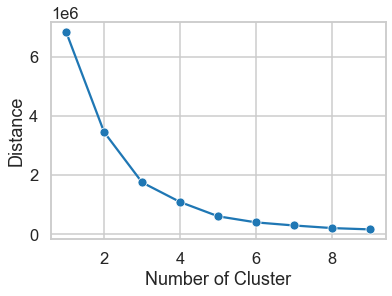

In [40]:
elbow_plot(df_user[['frequency']])

In [41]:
kmeans = KMeans(n_clusters=6).fit(df_user[['frequency']])
df_user['f_cluster'] = kmeans.predict(df_user[['frequency']])

In [42]:
df_user.groupby('f_cluster').frequency.describe()

,count,mean,std,min,25%,50%,75%,max
f_cluster,,,,,,,,
0,514.0,50.663424,13.167594,33.0,39.0,48.0,60.75,81.0
1,9.0,531.111111,110.351081,412.0,436.0,522.0,582.00,730.0
2,32.0,214.562500,46.236375,165.0,181.0,202.0,229.25,345.0
3,143.0,111.923077,21.366710,82.0,93.0,110.0,127.50,162.0
4,1141.0,14.572305,8.674387,1.0,8.0,14.0,21.00,32.0
5,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.00,1364.0


In [43]:
df_user = cluster_order('f_cluster', 'frequency', df_user, True)

In [44]:
df_user.groupby('f_cluster').frequency.describe()

,count,mean,std,min,25%,50%,75%,max
f_cluster,,,,,,,,
0,1141.0,14.572305,8.674387,1.0,8.0,14.0,21.00,32.0
1,514.0,50.663424,13.167594,33.0,39.0,48.0,60.75,81.0
2,143.0,111.923077,21.366710,82.0,93.0,110.0,127.50,162.0
3,32.0,214.562500,46.236375,165.0,181.0,202.0,229.25,345.0
4,9.0,531.111111,110.351081,412.0,436.0,522.0,582.00,730.0
5,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.00,1364.0


### c. Monetary

In [45]:
df_3m['revenue'] = df_3m.unitprice * df_3m.quantity

revenue_df = df_3m.groupby('customerid').revenue.sum().reset_index()

revenue_df = revenue_df[revenue_df.customerid != 0]
revenue_df.head(3)

,customerid,revenue
1,12747.0,1082.09
2,12748.0,4336.73
3,12749.0,782.10


In [46]:
df_user = pd.merge(df_user, revenue_df, on='customerid')
df_user.head(3)

,customerid,recency,r_cluster,frequency,f_cluster,revenue
0,14620.0,12,3,30,0,393.28
1,14676.0,15,3,18,0,1144.77
2,14560.0,3,3,12,0,562.28


In [47]:
df_user.revenue.describe()

count     1840.000000
mean       738.715017
std       1640.430156
min      -1462.500000
25%        210.237500
50%        369.825000
75%        749.490000
max      35085.480000
Name: revenue, dtype: float64

In [192]:
df_user.revenue.mean()

738.715016847826

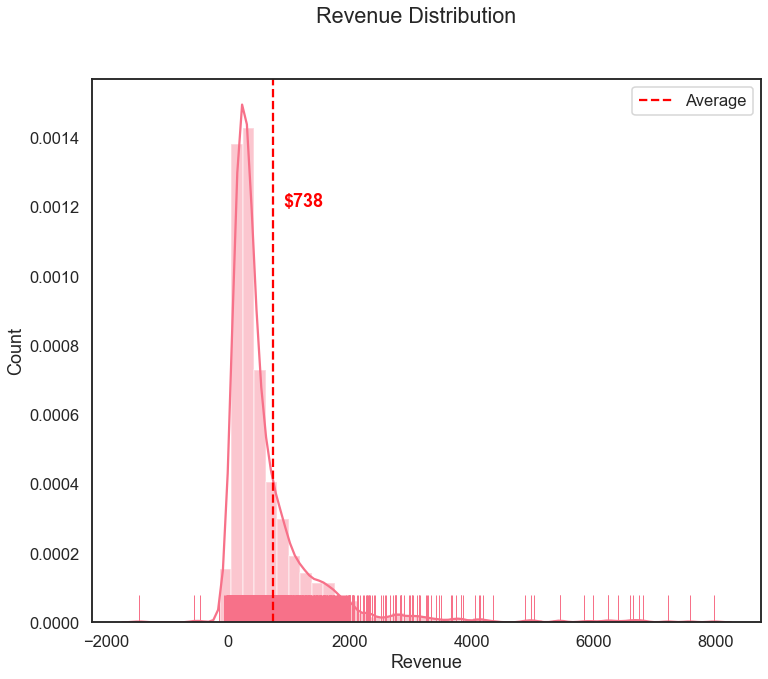

In [593]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,10))
sns.distplot(df_user.query('revenue<10000')['revenue'], rug=True)
ax.axvline(df_user.revenue.mean(), linestyle='--', color='r', label='Average')
ax.set_xlabel('Revenue'); ax.set_ylabel('Count'); fig.suptitle('Revenue Distribution')
ax.text(900,0.0012, '$738',size='medium', color='r', weight='semibold')
ax.legend()

We have negative revenue. Possibly product return

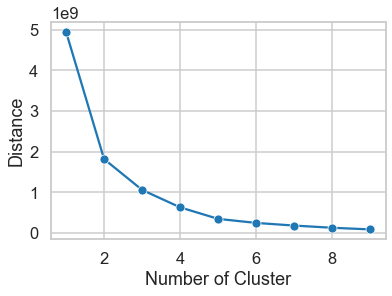

In [49]:
elbow_plot(df_user[['revenue']])

In [50]:
kmeans = KMeans(n_clusters=5).fit(df_user[['revenue']])
df_user['re_cluster'] = kmeans.predict(df_user[['revenue']])

In [51]:
df_user.groupby('re_cluster').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
re_cluster,,,,,,,,
0,1523.0,361.681464,243.468293,-1462.50,181.0200,309.350,489.8100,997.01
1,10.0,14092.686000,2855.109881,10348.13,11268.3675,15124.345,16124.8250,17700.64
2,31.0,5149.540968,1392.707626,3403.01,3833.0050,4966.360,6313.8050,7969.99
3,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48
4,274.0,1630.046865,550.762596,997.58,1207.7725,1482.380,1849.3175,3321.64


In [52]:
df_user = cluster_order('re_cluster', 'revenue', df_user, True)

In [53]:
df_user.groupby('re_cluster').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
re_cluster,,,,,,,,
0,1523.0,361.681464,243.468293,-1462.50,181.0200,309.350,489.8100,997.01
1,274.0,1630.046865,550.762596,997.58,1207.7725,1482.380,1849.3175,3321.64
2,31.0,5149.540968,1392.707626,3403.01,3833.0050,4966.360,6313.8050,7969.99
3,10.0,14092.686000,2855.109881,10348.13,11268.3675,15124.345,16124.8250,17700.64
4,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48


### d. Overall Score

In [54]:
df_user.sample(5)

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster
1669,15819.0,7,3,77,1,1177.14,1
734,16250.0,69,0,10,0,163.30,0
1550,12980.0,18,2,4,0,1731.42,1
511,12933.0,91,0,9,0,109.50,0
1037,15755.0,43,1,18,0,306.05,0


In [55]:
# Average score of each cluster
df_user['score'] = df_user.r_cluster + df_user.f_cluster + df_user.re_cluster
df_user.groupby('score')['recency', 'frequency', 'revenue'].mean()

,recency,frequency,revenue
score,,,
0,77.346863,11.959410,224.447196
1,54.468493,19.813699,310.270247
2,33.698061,25.731302,408.384903
3,16.646778,30.606205,476.570716
4,14.037234,52.484043,946.739947
5,9.780488,75.943089,1570.285211
6,8.628571,114.157143,2594.711714
7,6.541667,185.333333,3313.487917
8,7.000000,264.000000,11216.033636


In [56]:
# Total customer within each cluster
df_user.groupby('score').customerid.count()

score
0     271
1     365
2     361
3     419
4     188
5     123
6      70
7      24
8      11
9       5
10      3
Name: customerid, dtype: int64

In [57]:
low_value = df_user[df_user.score.isin([0, 1, 2])]
print(f'There are {len(low_value)} of customer in Low Value group with a total of ${low_value.revenue.sum():.2f} in revenue')

mid_value = df_user[df_user.score.isin([3, 4, 5])]
print(f'There are {len(mid_value)} of customer in Mid Value group with a total of ${mid_value.revenue.sum():.2f} in revenue')

high_value = df_user[df_user.score.isin([6, 7, 8])]
print(f'There are {len(high_value)} of customer in High Value group with a total of ${high_value.revenue.sum():.2f} in revenue')

vip = df_user[df_user.score.isin([9,10])]
print(f'There are {len(vip)} of customer in VIP group with a total of ${vip.revenue.sum():.2f} in revenue')

There are 997 of customer in Low Value group with a total of $321500.78 in revenue
There are 730 of customer in Mid Value group with a total of $570815.32 in revenue
There are 105 of customer in High Value group with a total of $384529.90 in revenue
There are 8 of customer in VIP group with a total of $82389.63 in revenue


In [58]:
print(f'Average spending in Low Value: ${low_value.revenue.sum()/len(low_value):.2f} /person')
print(f'Average spending in Mid Value: ${mid_value.revenue.sum()/len(mid_value):.2f} /person')
print(f'Average spending in High Value: ${high_value.revenue.sum()/len(high_value):.2f} /person')
print(f'Average spending in Vip Value: ${vip.revenue.sum()/len(vip):.2f} /person')

Average spending in Low Value: $322.47 /person
Average spending in Mid Value: $781.94 /person
Average spending in High Value: $3662.19 /person
Average spending in Vip Value: $10298.70 /person


In [59]:
df_user['segment'] = 'Low-Value'
df_user.loc[df_user.score > 2, 'segment'] = 'Mid-Value'
df_user.loc[df_user.score > 5, 'segment'] = 'High-Value'
df_user.loc[df_user.score > 8, 'segment'] = 'VIP'

In [60]:
df_user.sample(5)

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,segment
342,16965.0,34,2,26,0,201.19,0,2,Low-Value
1086,14085.0,5,3,117,2,824.50,0,5,Mid-Value
1512,13735.0,42,1,62,1,915.01,0,2,Low-Value
691,17795.0,72,0,17,0,163.25,0,0,Low-Value
857,13626.0,60,1,19,0,257.23,0,1,Low-Value


In [61]:
# Identify VIP customer
df_user[df_user.segment == 'VIP']

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,segment
1821,15039.0,6,3,436,4,6741.59,2,9,VIP
1822,12748.0,0,3,582,4,4336.73,2,9,VIP
1823,14769.0,9,3,558,4,4966.36,2,9,VIP
1827,17841.0,0,3,1364,5,5985.21,2,10,VIP
1834,15311.0,4,3,522,4,16309.61,3,10,VIP
1835,13089.0,5,3,452,4,11757.87,3,10,VIP
1836,14298.0,27,2,433,4,14984.73,3,9,VIP
1837,17511.0,14,3,199,3,17307.53,3,9,VIP


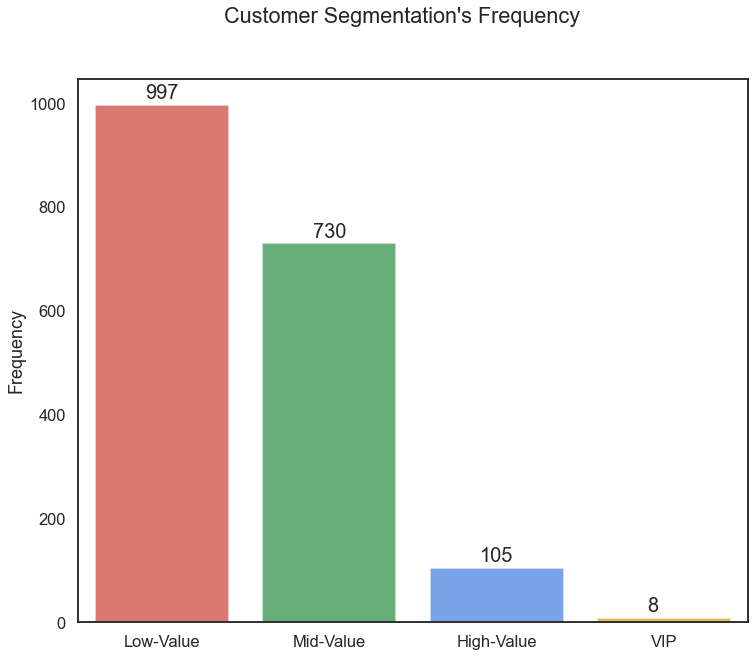

In [643]:
sns.set_style('white')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(df_user.segment, alpha=0.8, order=['Low-Value', 'Mid-Value', 'High-Value', 'VIP'],
             palette={'Low-Value': Red, 'Mid-Value': Green, 'High-Value':Blue, 'VIP':Yellow})

for i in ax.patches:
    ax.text(i.get_x()+0.3, i.get_height()+12, i.get_height(), fontsize=20)

ax.set_ylabel('Frequency')
ax.set_xlabel('')
fig.suptitle("Customer Segmentation's Frequency" )

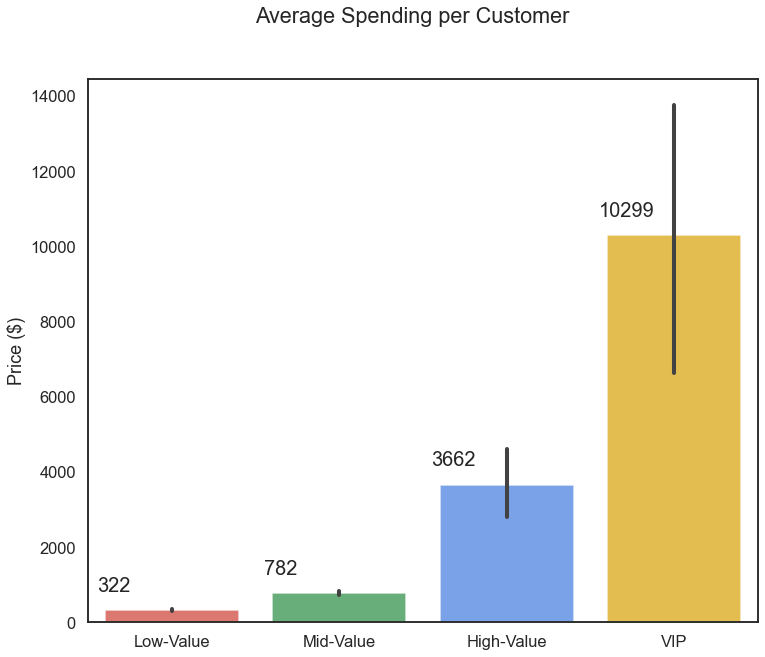

In [651]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x='segment', y='revenue', data=df_user, alpha=0.8, order=['Low-Value', 'Mid-Value', 'High-Value', 'VIP'],
           palette={'Low-Value': Red, 'Mid-Value': Green, 'High-Value':Blue, 'VIP':Yellow})

for i in ax.patches:
    ax.text(i.get_x()-0.05, i.get_height()+500, int(i.get_height().round()), fontsize=20)
    

ax.set_ylabel('Price ($)')
ax.set_xlabel('')
fig.suptitle('Average Spending per Customer')

In [574]:
total_rev = low_value.revenue.sum() + mid_value.revenue.sum() + high_value.revenue.sum() + vip.revenue.sum()
low_per = (low_value.revenue.sum())/total_rev
mid_per = (mid_value.revenue.sum())/ total_rev
high_per = (high_value.revenue.sum())/ total_rev
vip_per = (vip.revenue.sum())/ total_rev

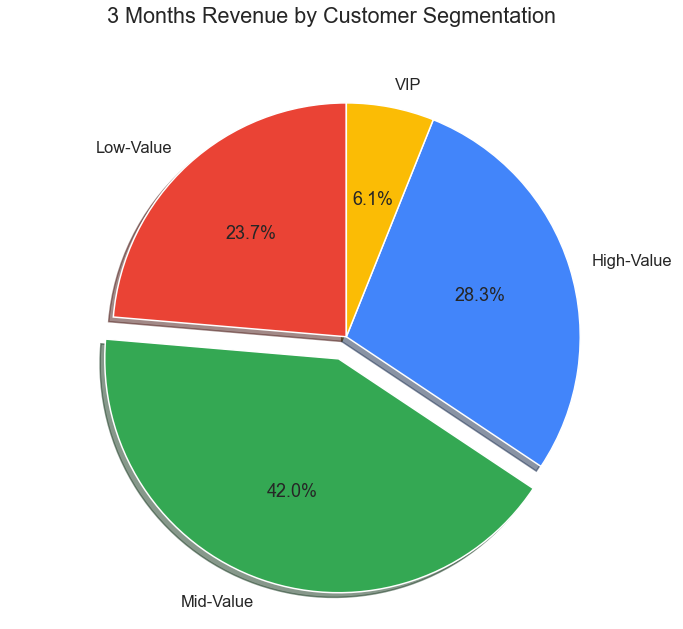

In [645]:
plt.figure(figsize=(12,10))
labels = 'Low-Value', 'Mid-Value', 'High-Value', 'VIP'
frequency = [low_per, mid_per, high_per, vip_per]

explode = (0, 0.1, 0, 0)  
plt.pie(frequency, explode=explode, labels=labels,colors=[Red, Green, Blue, Yellow], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal') 
plt.suptitle('3 Months Revenue by Customer Segmentation')

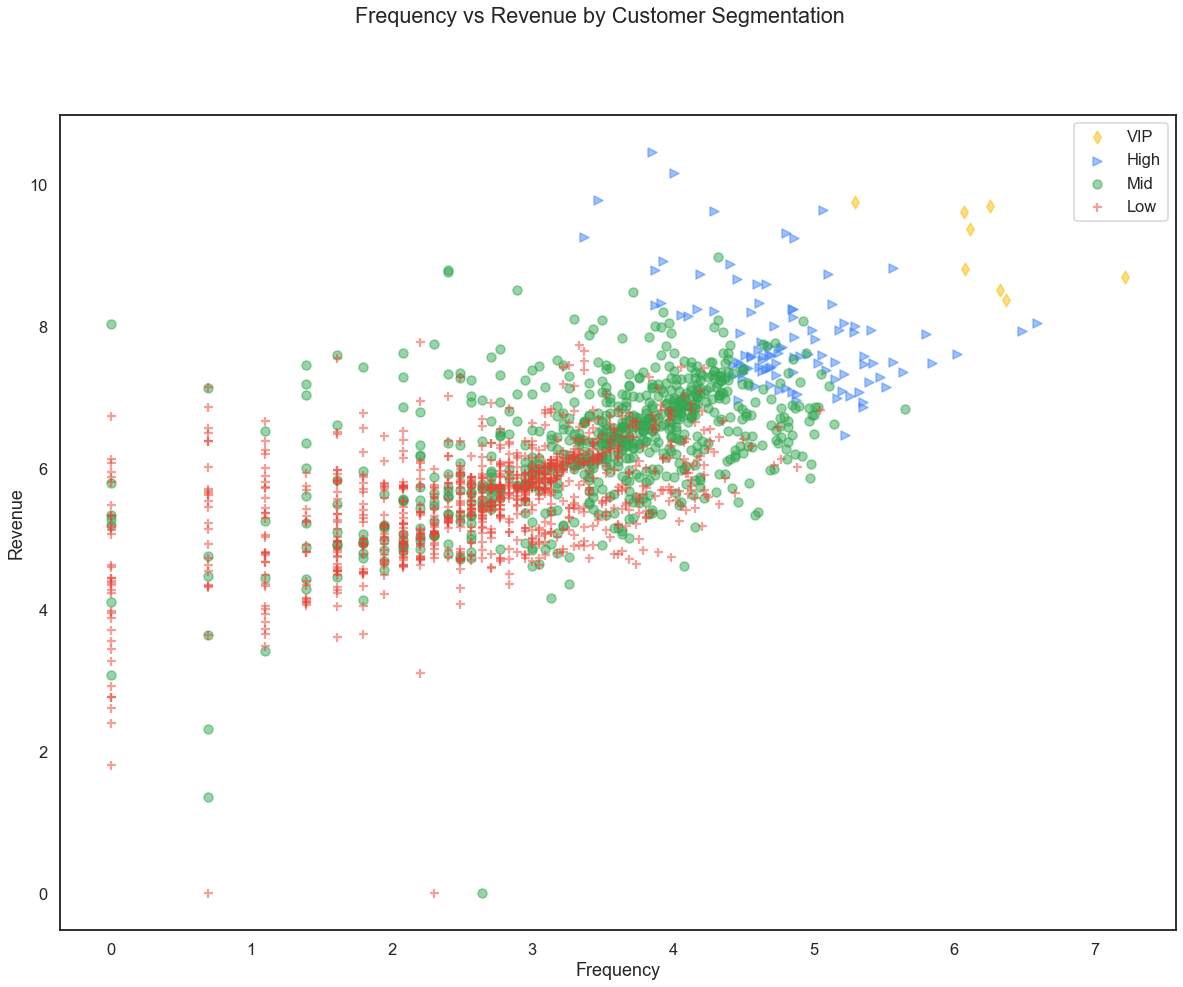

In [650]:
fig, ax = plt.subplots(figsize=(20,15))
sns.set_style('white')
sns.set_context('talk')

ax.scatter(np.log(df_user.query('segment == "VIP"')['frequency']), np.log(df_user.query('segment == "VIP"')['revenue']+1), marker='d', alpha=0.5,color=Yellow ,label='VIP')
ax.scatter(np.log(df_user.query('segment == "High-Value"')['frequency']), np.log(df_user.query('segment == "High-Value"')['revenue']+1), marker='>', alpha=0.5,color=Blue ,label='High')
ax.scatter(np.log(df_user.query('segment == "Mid-Value"')['frequency']), np.log(df_user.query('segment == "Mid-Value"')['revenue']+1), marker='o', alpha=0.5,color=Green ,label='Mid')
ax.scatter(np.log(df_user.query('segment == "Low-Value"')['frequency']), np.log(df_user.query('segment == "Low-Value"')['revenue']+1), marker='+', alpha=0.5,color=Red ,label='Low')
ax.set_xlabel('Frequency')
ax.set_ylabel('Revenue')
fig.suptitle('Frequency vs Revenue by Customer Segmentation')

plt.legend()

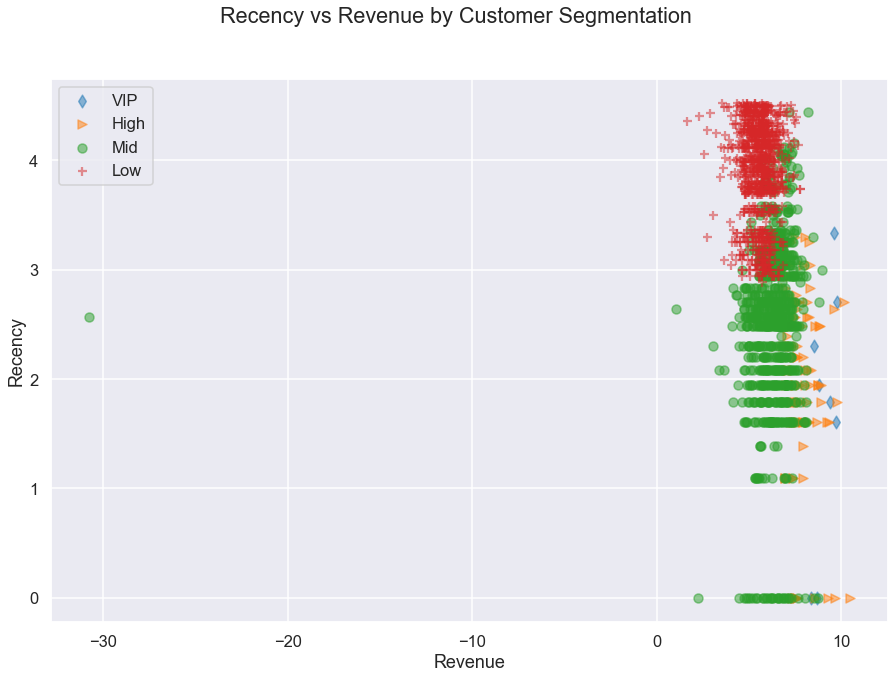

In [253]:
fig, ax = plt.subplots(figsize=(15,10))
sns.set_style('darkgrid')

ax.scatter(np.log(df_user.query('segment == "VIP"')['revenue']), np.log(df_user.query('segment == "VIP"')['recency']+1), marker='d', alpha=0.5, label='VIP')
ax.scatter(np.log(df_user.query('segment == "High-Value"')['revenue']), np.log(df_user.query('segment == "High-Value"')['recency']+1), marker='>', alpha=0.5, label='High')
ax.scatter(np.log(df_user.query('segment == "Mid-Value"')['revenue']), np.log(df_user.query('segment == "Mid-Value"')['recency']+1), marker='o', alpha=0.5, label='Mid')
ax.scatter(np.log(df_user.query('segment == "Low-Value"')['revenue']), np.log(df_user.query('segment == "Low-Value"')['recency']+1), marker='+', alpha=0.5, label='Low')
ax.set_xlabel('Revenue')
ax.set_ylabel('Recency')
fig.suptitle('Recency vs Revenue by Customer Segmentation')

plt.legend()
plt.show()

### e. Investigate customer id 15749 with -1462 revenue

In [64]:
df_user.revenue.describe()

count     1840.000000
mean       738.715017
std       1640.430156
min      -1462.500000
25%        210.237500
50%        369.825000
75%        749.490000
max      35085.480000
Name: revenue, dtype: float64

In [65]:
df_user[df_user.revenue < -1400]

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,segment
1034,15749.0,43,1,10,0,-1462.5,0,1,Low-Value


In [66]:
df[df.customerid == 15749]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
49433,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom
49434,540815,21175,GIN + TONIC DIET METAL SIGN,2000,2011-01-11 12:55:00,1.85,15749.0,United Kingdom
49435,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom
49495,540818,47556B,TEA TIME TEA TOWELS,1300,2011-01-11 12:57:00,2.55,15749.0,United Kingdom
49496,540818,48185,DOORMAT FAIRY CAKE,670,2011-01-11 12:57:00,6.75,15749.0,United Kingdom
147619,C550456,48185,DOORMAT FAIRY CAKE,-670,2011-04-18 13:08:00,6.75,15749.0,United Kingdom
147620,C550456,47566B,TEA TIME PARTY BUNTING,-1300,2011-04-18 13:08:00,2.55,15749.0,United Kingdom
147621,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2011-04-18 13:08:00,2.55,15749.0,United Kingdom
147622,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749.0,United Kingdom
147623,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749.0,United Kingdom


This customerid look like a test customer id for staff training. Possibly POS trainning 

## 3. Lifetime Value Prediction
### a. Identify LTV as target variable

Lifetime Value = Gross revenue - Cost

In [67]:
 df_user.head()

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,14560.0,3,3,12,0,562.28,0,3,Mid-Value
2,16389.0,13,3,16,0,670.17,0,3,Mid-Value
3,13094.0,13,3,9,0,481.44,0,3,Mid-Value
4,18218.0,14,3,24,0,626.38,0,3,Mid-Value


In [68]:
df_6m.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom


In [69]:
# Since we don't have cost in our data, the revenue become LTV
df_6m['revenue'] = df_6m.unitprice * df_6m.quantity

In [70]:
df_user_6m = df_6m.groupby('customerid').revenue.sum().reset_index()
df_user_6m.rename(columns={'revenue': 'm6_revenue'}, inplace=True)

In [71]:
# Join 3m data and 6m data (the revenue is the target variable for all customer presented in
# both dataset)
df_merge = pd.merge(df_user, df_user_6m, on='customerid', how='left')

In [72]:
df_merge.isnull().sum()

customerid      0
recency         0
r_cluster       0
frequency       0
f_cluster       0
revenue         0
re_cluster      0
score           0
segment         0
m6_revenue    449
dtype: int64

In [73]:
# Remove new customer for simplicity
df_merge = df_merge.fillna(0)

In [74]:
df_merge.groupby('segment')['m6_revenue'].mean()

segment
High-Value     8205.462000
Low-Value       573.385667
Mid-Value      1511.541768
VIP           22643.925000
Name: m6_revenue, dtype: float64

In [75]:
df_merge.groupby('segment')['m6_revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
High-Value,105.0,8205.462000,21782.684635,-25.00,2035.5700,3463.340,6567.9700,180469.05
Low-Value,997.0,573.385667,872.480169,-609.40,0.0000,302.450,774.3600,10846.10
Mid-Value,730.0,1511.541768,3018.814174,-133.50,245.0525,841.545,1707.5425,41378.68
VIP,8.0,22643.925000,12973.372947,4472.43,15732.5650,25047.220,27150.4125,45269.64


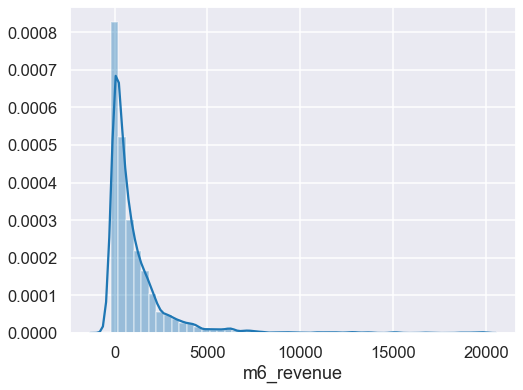

In [76]:
plt.figure(figsize=(8,6))
sns.distplot(df_merge.query('m6_revenue < 20000')['m6_revenue'])

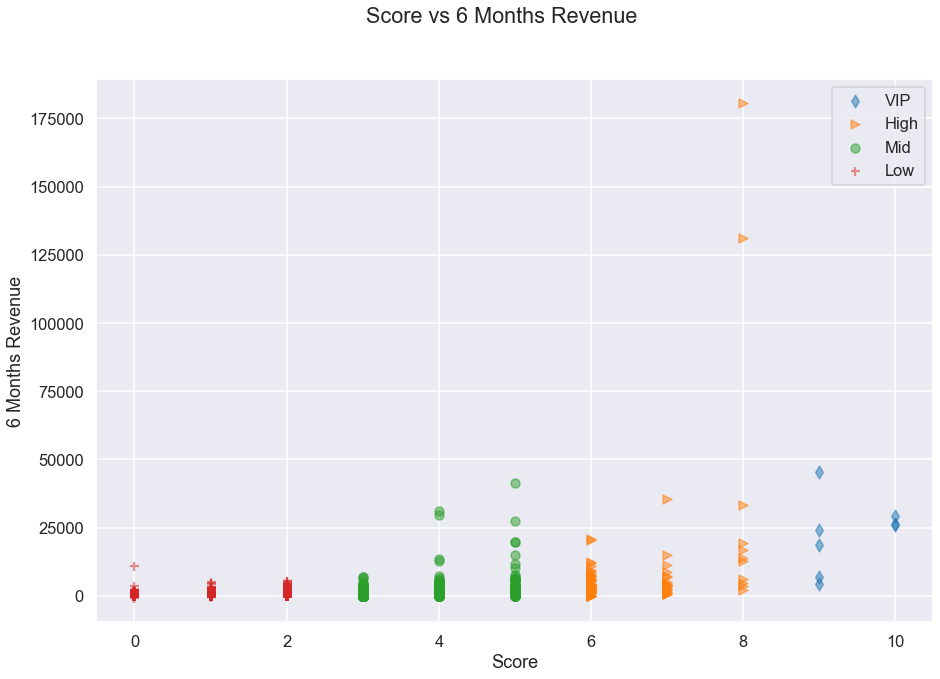

In [77]:
fig, ax = plt.subplots(figsize=(15,10))
sns.set_style('darkgrid')

ax.scatter(df_merge.query('segment == "VIP"')['score'], df_merge.query('segment == "VIP"')['m6_revenue'], marker='d', alpha=0.5, label='VIP')
ax.scatter(df_merge.query('segment == "High-Value"')['score'],df_merge.query('segment == "High-Value"')['m6_revenue'], marker='>', alpha=0.5, label='High')
ax.scatter(df_merge.query('segment == "Mid-Value"')['score'],df_merge.query('segment == "Mid-Value"')['m6_revenue'], marker='o', alpha=0.5, label='Mid')
ax.scatter(df_merge.query('segment == "Low-Value"')['score'], df_merge.query('segment == "Low-Value"')['m6_revenue'], marker='+', alpha=0.5, label='Low')
ax.set_xlabel('Score')
ax.set_ylabel('6 Months Revenue')
fig.suptitle('Score vs 6 Months Revenue')

plt.legend()
plt.show()

High score has higher revenue (Positive Correlation)

In [78]:
# Remove outliers
df_cluster = df_merge[df_merge.m6_revenue < df_merge.m6_revenue.quantile(0.99)]
df_cluster

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,segment,m6_revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00
1,14560.0,3,3,12,0,562.28,0,3,Mid-Value,911.33
2,16389.0,13,3,16,0,670.17,0,3,Mid-Value,692.10
3,13094.0,13,3,9,0,481.44,0,3,Mid-Value,774.78
4,18218.0,14,3,24,0,626.38,0,3,Mid-Value,0.00
...,...,...,...,...,...,...,...,...,...,...
1824,17107.0,16,3,169,3,4118.81,2,8,High-Value,6261.62
1825,13081.0,11,3,261,3,6808.80,2,8,High-Value,13781.27
1828,16333.0,0,3,29,0,10578.72,3,6,High-Value,11992.40
1830,16422.0,4,3,129,2,10348.13,3,8,High-Value,16756.31


The m6_revenue is a regressor problem. However, we want to cluster them into 4 group for classification problem. It is easier to implement strategy on a group of customer rather then individual.  

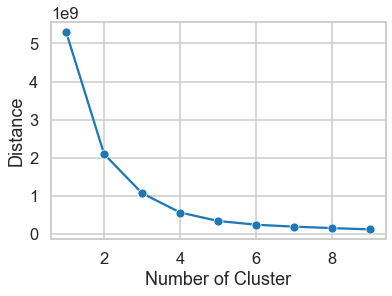

In [79]:
elbow_plot(df_cluster[['m6_revenue']])

In [80]:
kmeans = KMeans(n_clusters=4).fit(df_cluster[['m6_revenue']])
df_cluster['LTV_cluster'] = kmeans.predict(df_cluster[['m6_revenue']])

In [81]:
df_cluster = cluster_order('LTV_cluster', 'm6_revenue', df_cluster, True)

In [82]:
df_cluster.groupby('LTV_cluster').m6_revenue.describe()

,count,mean,std,min,25%,50%,75%,max
LTV_cluster,,,,,,,,
0,1268.0,310.448960,334.109079,-609.40,0.0000,231.330,556.8750,1085.81
1,426.0,1860.744085,589.163565,1090.10,1361.4000,1707.395,2195.0475,3388.08
2,109.0,4910.002385,1271.802276,3406.00,3865.0200,4418.200,5894.8700,7946.90
3,18.0,11999.407222,2304.421735,8603.26,10258.6625,11861.385,13366.3975,16756.31


0 = Low LTV <br>
1 = Mid LTV <br>
2 = High LTV <br>
3 = Extreme LTV <br>

In [83]:
df_cluster.head()

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,segment,m6_revenue,LTV_cluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,14560.0,3,3,12,0,562.28,0,3,Mid-Value,911.33,0
2,16389.0,13,3,16,0,670.17,0,3,Mid-Value,692.10,0
3,13094.0,13,3,9,0,481.44,0,3,Mid-Value,774.78,0
4,18218.0,14,3,24,0,626.38,0,3,Mid-Value,0.00,0


In [84]:
# OneHot Encoding
data = pd.get_dummies(df_cluster)

In [85]:
data.head()

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,m6_revenue,LTV_cluster,segment_High-Value,segment_Low-Value,segment_Mid-Value,segment_VIP
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1,0
1,14560.0,3,3,12,0,562.28,0,3,911.33,0,0,0,1,0
2,16389.0,13,3,16,0,670.17,0,3,692.10,0,0,0,1,0
3,13094.0,13,3,9,0,481.44,0,3,774.78,0,0,0,1,0
4,18218.0,14,3,24,0,626.38,0,3,0.00,0,0,0,1,0


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1821 entries, 0 to 1820
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerid          1821 non-null   float64
 1   recency             1821 non-null   int64  
 2   r_cluster           1821 non-null   int64  
 3   frequency           1821 non-null   int64  
 4   f_cluster           1821 non-null   int64  
 5   revenue             1821 non-null   float64
 6   re_cluster          1821 non-null   int64  
 7   score               1821 non-null   int64  
 8   m6_revenue          1821 non-null   float64
 9   LTV_cluster         1821 non-null   int64  
 10  segment_High-Value  1821 non-null   uint8  
 11  segment_Low-Value   1821 non-null   uint8  
 12  segment_Mid-Value   1821 non-null   uint8  
 13  segment_VIP         1821 non-null   uint8  
dtypes: float64(3), int64(7), uint8(4)
memory usage: 163.6 KB


###  b. t-SNE Visualization

In [87]:
# Instantiate t-SNE
m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(data)

In [88]:
# Create dataframe for visualization
df_cluster['x'] = tsne_features[:,0]
df_cluster['y'] = tsne_features[:,1]
df_cluster.head(3)

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,segment,m6_revenue,LTV_cluster,x,y
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0,34.473656,-6.815053
1,14560.0,3,3,12,0,562.28,0,3,Mid-Value,911.33,0,9.910448,-16.755169
2,16389.0,13,3,16,0,670.17,0,3,Mid-Value,692.10,0,-3.231819,18.726328


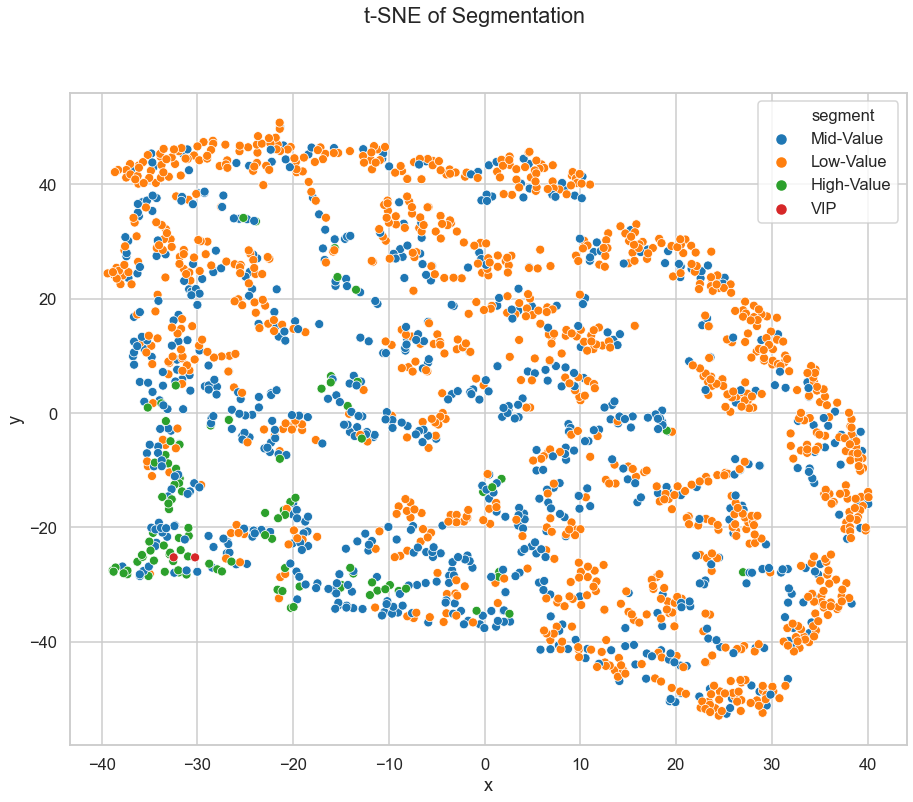

In [131]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='x', y='y', hue='segment', data=df_cluster)
plt.suptitle('t-SNE of Segmentation')

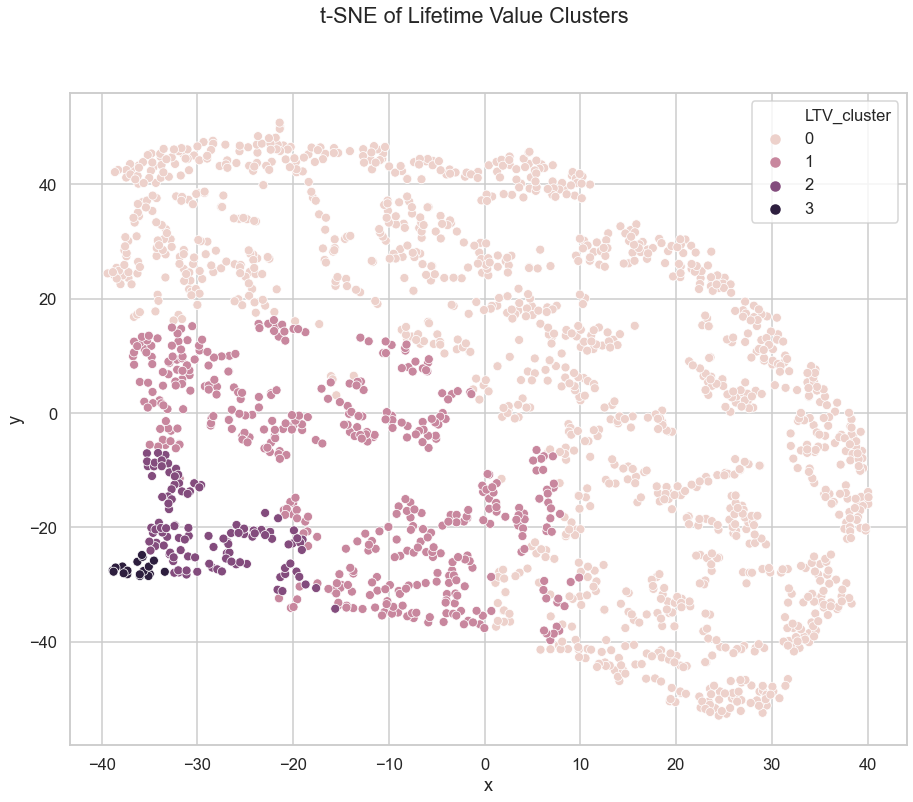

In [130]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='x', y='y', hue='LTV_cluster', data=df_cluster)
plt.suptitle('t-SNE of Lifetime Value Clusters')

In [652]:
data.head()

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,m6_revenue,LTV_cluster,segment_High-Value,segment_Low-Value,segment_Mid-Value,segment_VIP
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1,0
1,14560.0,3,3,12,0,562.28,0,3,911.33,0,0,0,1,0
2,16389.0,13,3,16,0,670.17,0,3,692.10,0,0,0,1,0
3,13094.0,13,3,9,0,481.44,0,3,774.78,0,0,0,1,0
4,18218.0,14,3,24,0,626.38,0,3,0.00,0,0,0,1,0


In [654]:
ltv0 = data[data.LTV_cluster == 0]
ltv1 = data[data.LTV_cluster == 1]
ltv2 = data[data.LTV_cluster == 2]
ltv3 = data[data.LTV_cluster == 3]

In [657]:
total = data.m6_revenue.sum()
total

1937505.8510000003

In [671]:
print(f' Total customer in LTV0: {len(ltv0)}')
print(f' Total customer in LTV1: {len(ltv1)}')
print(f' Total customer in LTV2: {len(ltv2)}')
print(f' Total customer in LTV3: {len(ltv3)}')

 Total customer in LTV0: 1268
 Total customer in LTV1: 426
 Total customer in LTV2: 109
 Total customer in LTV3: 18


In [673]:
print(f' Average spending per customer in LTV0: ${(ltv0.m6_revenue.sum()) / len(ltv0):.2f}')
print(f' Average spending per customer in LTV1: ${(ltv1.m6_revenue.sum()) / len(ltv1):.2f}')
print(f' Average spending per customer in LTV2: ${(ltv2.m6_revenue.sum()) / len(ltv2):.2f}')
print(f' Average spending per customer in LTV3: ${(ltv3.m6_revenue.sum()) / len(ltv3):.2f}')

 Average spending per customer in LTV0: $310.45
 Average spending per customer in LTV1: $1860.74
 Average spending per customer in LTV2: $4910.00
 Average spending per customer in LTV3: $11999.41


In [663]:
ltv0_per = ltv0.m6_revenue.sum()/total
ltv1_per = ltv1.m6_revenue.sum()/total
ltv2_per = ltv2.m6_revenue.sum()/total
ltv3_per = ltv3.m6_revenue.sum()/total

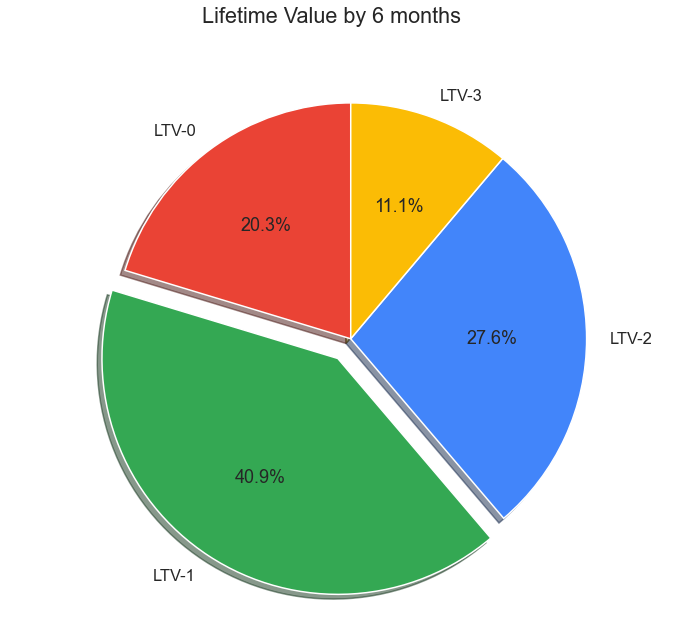

In [667]:
plt.figure(figsize=(12,10))
labels = 'LTV-0', 'LTV-1', 'LTV-2', 'LTV-3'
frequency = [ltv0_per, ltv1_per, ltv2_per, ltv3_per]

explode = (0, 0.1, 0, 0)  
plt.pie(frequency, explode=explode, labels=labels,colors=[Red, Green, Blue, Yellow], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal') 
plt.suptitle('Lifetime Value by 6 months')
plt.savefig('LTV-pie')

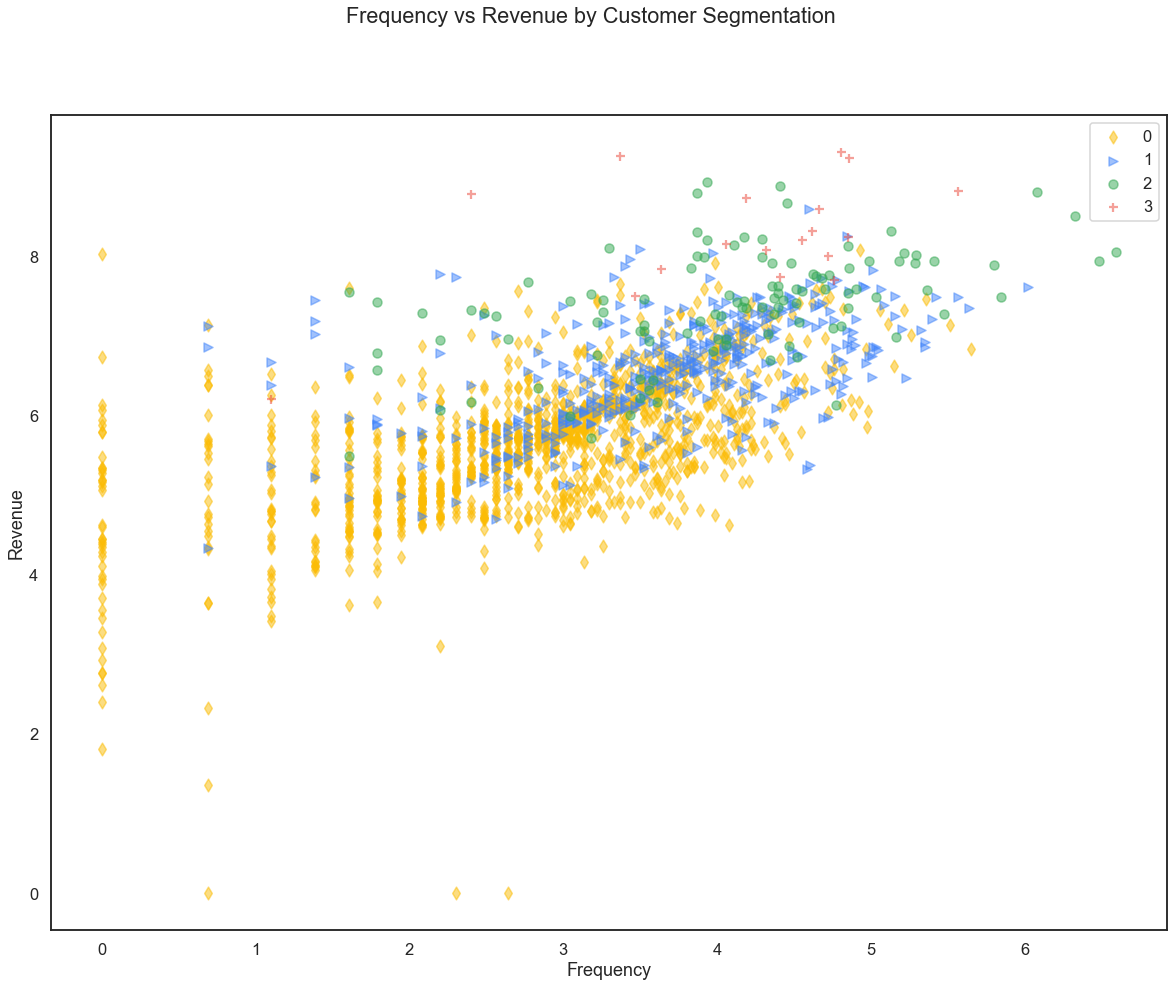

In [662]:
fig, ax = plt.subplots(figsize=(20,15))
sns.set_style('white')
sns.set_context('talk')

ax.scatter(np.log(data.query('LTV_cluster == 0')['frequency']), np.log(data.query('LTV_cluster == 0')['revenue']+1), marker='d', alpha=0.5,color=Yellow ,label='0')
ax.scatter(np.log(data.query('LTV_cluster == 1')['frequency']), np.log(data.query('LTV_cluster == 1')['revenue']+1), marker='>', alpha=0.5,color=Blue ,label='1')
ax.scatter(np.log(data.query('LTV_cluster == 2')['frequency']), np.log(data.query('LTV_cluster == 2')['revenue']+1), marker='o', alpha=0.5,color=Green ,label='2')
ax.scatter(np.log(data.query('LTV_cluster == 3')['frequency']), np.log(data.query('LTV_cluster == 3')['revenue']+1), marker='+', alpha=0.5,color=Red ,label='3')
ax.set_xlabel('Frequency')
ax.set_ylabel('Revenue')
fig.suptitle('Frequency vs Revenue by Customer Segmentation')

plt.legend()

### c. Removing highly correlated features

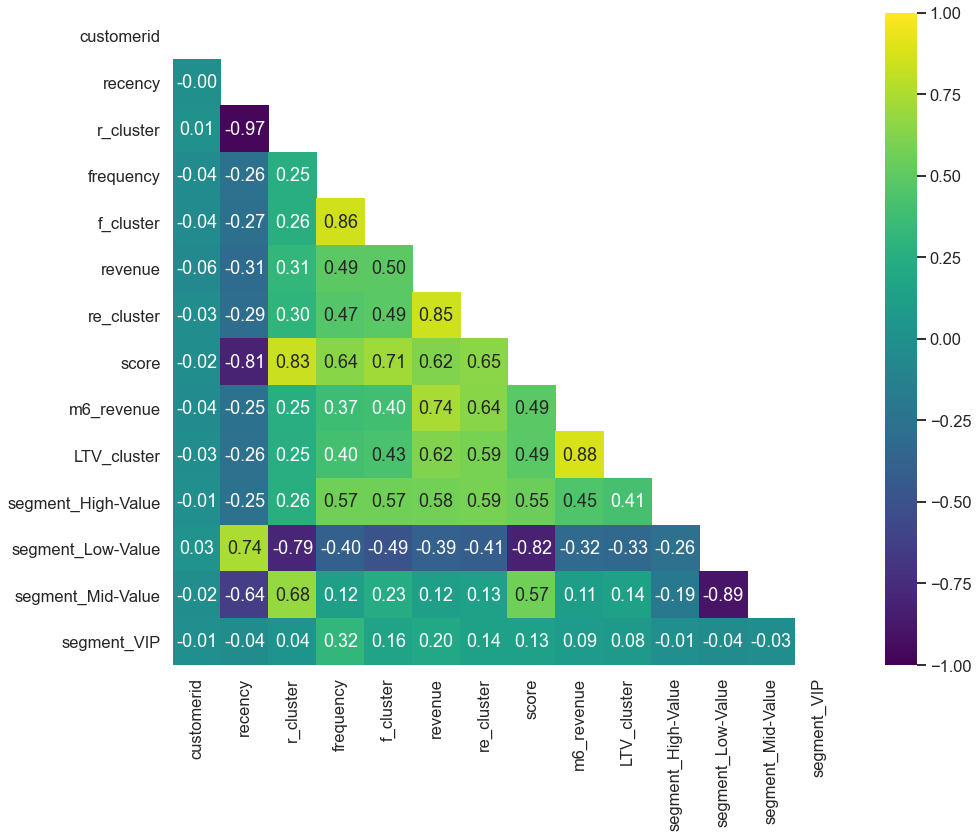

In [91]:
# Correlation
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), mask=mask, annot=True,fmt='.2f',  cmap='viridis', vmin=-1, vmax=1, center=0)

In [92]:
corr = data.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=bool))

corr_matrix = corr.mask(mask)

to_drop = [c for c in corr_matrix.columns if any(corr_matrix[c] > 0.85)]

print(to_drop)

['recency', 'frequency', 'm6_revenue', 'segment_Low-Value']


In [93]:
feature_corr_removed = data.drop(to_drop, axis=1)
feature_corr_removed.head(3)

,customerid,r_cluster,f_cluster,revenue,re_cluster,score,LTV_cluster,segment_High-Value,segment_Mid-Value,segment_VIP
0,14620.0,3,0,393.28,0,3,0,0,1,0
1,14560.0,3,0,562.28,0,3,0,0,1,0
2,16389.0,3,0,670.17,0,3,0,0,1,0


### d. Combining feature selectors (LassoCV, Ensemble, RFE) 

In [297]:
# Set up test dataframe
test = data.copy()

In [298]:
test.LTV_cluster.value_counts(normalize=True)

0    0.696321
1    0.233937
2    0.059857
3    0.009885
Name: LTV_cluster, dtype: float64

In [299]:
# Transform to binary target variable
test.loc[test.LTV_cluster.isin([1,2,3]), 'LTV_cluster'] = 1
test.LTV_cluster.value_counts(normalize=True)

0    0.696321
1    0.303679
Name: LTV_cluster, dtype: float64

In [307]:
# Testing LassoCV with best alpha, and feature != 0 coefficient
Xs, Xt, ys, yt = train_test_split(test.drop('LTV_cluster', axis=1), 
                                  test['LTV_cluster'],
                                  test_size=0.2,
                                  random_state=42)
scale = StandardScaler()
Xs_scaled = scale.fit_transform(Xs)
Xt_scaled = scale.transform(Xt)

lcv = LassoCV()
lcv.fit(Xs_scaled, ys)
lcv_mask = lcv.coef_ != 0

print(f'Number of Feature: {len(Xs.columns)}')
print(f'Best Alpha: {lcv.alpha_}')
print(f'The model explains {lcv.score(Xt_scaled, yt)} of the test set variance')
print(f'{sum(lcv_mask)} features out of {len(lcv_mask)} selected')

Number of Feature: 13
Best Alpha: 0.00030237974843407657
The model explains 0.5173349430043277 of the test set variance
11 features out of 13 selected


In [337]:
# Testing GradientBoosting(Boosting) with 10 features by RFE
rfe_gb = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=10, step=1, verbose=1)

rfe_gb.fit(Xs_scaled, ys)
print(f'The model explains {rfe_gb.score(Xt_scaled, yt)} of the test set variance')

gb_mask = rfe_gb.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
The model explains 1.0 of the test set variance


In [338]:
# Testing RandomForest(Bagging) with 10 features by RFE
rfe_rf = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1, verbose=1)

rfe_rf.fit(Xs_scaled, ys)
print(f'The model explains {rfe_rf.score(Xt_scaled, yt)} of the test set variance')

rf_mask = rfe_rf.support_

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
The model explains 1.0 of the test set variance


In [339]:
# Compute votes from 3 models
votes = np.sum([lcv_mask, gb_mask, rf_mask], axis=0)
votes

array([3, 3, 2, 3, 2, 3, 3, 2, 3, 1, 2, 2, 2])

In [340]:
# Select features picked by all models
X_features = test.drop('LTV_cluster', axis=1)

meta_mask = votes >= 3

X_reduced = X_features.loc[:, meta_mask]
X_reduced.head(3)

,customerid,recency,frequency,revenue,re_cluster,m6_revenue
0,14620.0,12,30,393.28,0,0.00
1,14560.0,3,12,562.28,0,911.33
2,16389.0,13,16,670.17,0,692.10


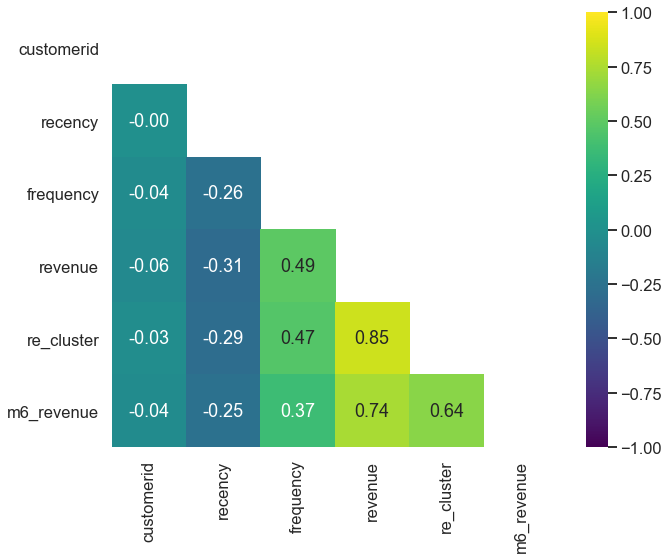

In [341]:
# Correlation from selected features by 3 models
mask = np.triu(np.ones_like(X_reduced.corr(), dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(X_reduced.corr(), mask=mask, annot=True, fmt='.2f', cmap='viridis', vmin=-1, vmax=1, center=0)

### e. Prediction with XGBOOST

In [346]:
X = data[['recency', 'frequency', 'revenue']]
y = data['LTV_cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

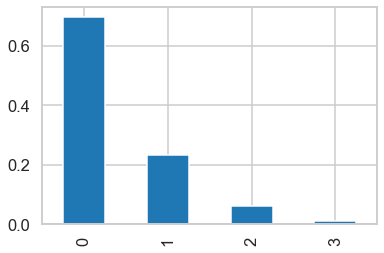

In [347]:
data.LTV_cluster.value_counts(normalize=True).plot.bar()

In [358]:
from sklearn.utils.class_weight import compute_class_weight

#### Class weight function for Imbalanced Data

In [545]:
def find_class_weight(y_train):
    """Compute individual weight for each of the classes.
    Output: array of weights with the same row as y_train
    """
    
    n_classes = len(np.unique(y_train))
    class_weight = list(len(y_train) / (n_classes * np.bincount(y_train)))
    # Instantiate empty array with the same size as y_train
    weight_array = np.ones(y_train.shape[0], dtype='float')
    
    for i, val in enumerate(y_train):
        weight_array[i] = class_weight[val]
    return weight_array

In [696]:
y_train.value_counts(normalize=True)

0    0.697115
1    0.234890
2    0.057692
3    0.010302
Name: LTV_cluster, dtype: float64

In [544]:
# Use sklearn compute class weight function 
#class_weight = len(y_train) / (4 * np.bincount(y_train))
#classes = np.unique(y_train)

#weight = list(compute_class_weight(class_weight='balanced', classes=classes, y=y_train))

In [522]:
w_array = find_class_weight(y_train)
print(w[120:130])
print(y_train[120:130].values)

[ 0.35862069  0.35862069 24.26666667  4.33333333  0.35862069  0.35862069
  0.35862069  0.35862069  1.06432749  0.35862069]
[0 0 3 2 0 0 0 0 1 0]


In [523]:
xgb_model = xgb.XGBClassifier(n_estimators=100,  
                              max_depth=5, 
                              learning_rate=0.005, 
                              objective= 'multi:softprob',
                              n_jobs=-1, 
                              tree_method='gpu_hist', 
                              gpu_id=0, 
                              random_state=42
                             )

xgb_model.fit(X_train, y_train, sample_weight=w_array)
print(f'Accuracy of XGB classifier on training set: {xgb_model.score(X_train, y_train)}')
print(f'Accuracy of XGB classifier on test set: {xgb_model.score(X_test, y_test)}')

Accuracy of XGB classifier on training set: 0.7431318681318682
Accuracy of XGB classifier on test set: 0.684931506849315


In [524]:
cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy').mean()

0.5199473129610117

In [419]:
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       253
           1       0.42      0.58      0.49        84
           2       0.36      0.52      0.43        25
           3       0.50      0.67      0.57         3

    accuracy                           0.68       365
   macro avg       0.54      0.63      0.57       365
weighted avg       0.74      0.68      0.70       365



### TUNNING PARAMETERS

In [546]:
space = {'max_depth': hp.quniform('max_depth', 3,18,1),
         'gamma': hp.uniform('gamma', 1,9), 
         'reg_alpha': hp.quniform('reg_alpha', 40, 180,1), 
         'reg_lambda': hp.uniform('reg_lambda', 0,1), 
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5,1), 
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1), 
         'n_estimators': hp.uniform('n_estimators', 100,500),
         'eta': hp.uniform('eta',0.01, 0.2),
         'seed': 42
        }

In [549]:
def objective(space):
    clf = xgb.XGBClassifier(n_estimators= int(space['n_estimators']), 
                            max_depth = int(space['max_depth']), 
                            gamma = space['gamma'], 
                            reg_alpha = int(space['reg_alpha']), 
                            min_child_weight = int(space['min_child_weight']), 
                            colsample_bytree = int(space['colsample_bytree']), 
                            eta = int(space['eta']),
                            random_state=42
                           )
    
    clf.fit(X_train, y_train, sample_weight=w_array, verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    print(f'Score: {accuracy}')
    return {'loss': accuracy, 'status': STATUS_OK}

In [550]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.003018 seconds
TPE using 0 trials


Score: 0.6931506849315069                              
  1%|          | 1/100 [00:00<00:26,  3.78trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 1/1 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
  2%|▏         | 2/100 [00:00<00:24,  4.06trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 2/2 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
  3%|▎         | 3/100 [00:00<00:24,  3.91trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 3/3 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
  4%|▍         | 4/100 [00:01<00:25,  3.79trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 4/4 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
  5%|▌         | 5/100 [00:01<00:26,  3.64trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 5/5 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
  6%|▌         | 6/100 [00:01<00:22,  4.23trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 6/6 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
  7%|▋         | 7/100 [00:01<00:20,  4.49trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 7/7 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
  8%|▊         | 8/100 [00:01<00:18,  5.03trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 8/8 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
  9%|▉         | 9/100 [00:01<00:15,  5.72trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 9/9 trials with best loss 0.693151


Score: 0.6931506849315069                                                        
 10%|█         | 10/100 [00:02<00:19,  4.71trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 10/10 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 11%|█         | 11/100 [00:02<00:18,  4.94trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 11/11 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 12%|█▏        | 12/100 [00:02<00:17,  5.16trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.004997 seconds
TPE using 12/12 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 13%|█▎        | 13/100 [00:02<00:16,  5.32trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 13/13 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 14%|█▍        | 14/100 [00:02<00:15,  5.64trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003999 seconds
TPE using 14/14 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 15%|█▌        | 15/100 [00:03<00:17,  4.93trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 15/15 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 16%|█▌        | 16/100 [00:03<00:17,  4.90trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 16/16 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 16%|█▌        | 16/100 [00:03<00:17,  4.90trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 17/17 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 18%|█▊        | 18/100 [00:03<00:15,  5.43trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 18/18 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 18%|█▊        | 18/100 [00:03<00:15,  5.43trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 19/19 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 20%|██        | 20/100 [00:03<00:14,  5.61trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 20/20 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 21%|██        | 21/100 [00:04<00:16,  4.84trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003999 seconds
TPE using 21/21 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 22%|██▏       | 22/100 [00:04<00:13,  5.71trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 22/22 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 23%|██▎       | 23/100 [00:04<00:14,  5.15trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 23/23 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 24%|██▍       | 24/100 [00:04<00:16,  4.62trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 24/24 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 25%|██▌       | 25/100 [00:04<00:13,  5.38trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 25/25 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 26%|██▌       | 26/100 [00:05<00:15,  4.88trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003997 seconds
TPE using 26/26 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 27%|██▋       | 27/100 [00:05<00:16,  4.43trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 27/27 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 28%|██▊       | 28/100 [00:05<00:13,  5.31trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 28/28 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 29%|██▉       | 29/100 [00:05<00:15,  4.59trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 29/29 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 30%|███       | 30/100 [00:06<00:16,  4.20trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 30/30 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 31%|███       | 31/100 [00:06<00:14,  4.88trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.004997 seconds
TPE using 31/31 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 32%|███▏      | 32/100 [00:06<00:16,  4.20trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 32/32 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 33%|███▎      | 33/100 [00:06<00:15,  4.29trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 33/33 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 34%|███▍      | 34/100 [00:06<00:13,  4.96trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 34/34 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 35%|███▌      | 35/100 [00:07<00:15,  4.20trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 35/35 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 36%|███▌      | 36/100 [00:07<00:15,  4.16trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 36/36 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 37%|███▋      | 37/100 [00:07<00:15,  4.19trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 37/37 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 38%|███▊      | 38/100 [00:07<00:13,  4.57trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 38/38 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 39%|███▉      | 39/100 [00:08<00:11,  5.28trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 39/39 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 40%|████      | 40/100 [00:08<00:11,  5.38trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 40/40 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 41%|████      | 41/100 [00:08<00:12,  4.72trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 41/41 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 42%|████▏     | 42/100 [00:08<00:13,  4.37trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 42/42 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 43%|████▎     | 43/100 [00:09<00:13,  4.19trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 43/43 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 44%|████▍     | 44/100 [00:09<00:13,  4.01trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 44/44 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 45%|████▌     | 45/100 [00:09<00:11,  4.79trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 45/45 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 46%|████▌     | 46/100 [00:09<00:10,  5.24trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 46/46 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 47%|████▋     | 47/100 [00:09<00:11,  4.65trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003997 seconds
TPE using 47/47 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 48%|████▊     | 48/100 [00:10<00:12,  4.10trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 48/48 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 49%|████▉     | 49/100 [00:10<00:12,  3.96trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 49/49 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 50%|█████     | 50/100 [00:10<00:11,  4.19trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 50/50 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 51%|█████     | 51/100 [00:10<00:11,  4.45trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 51/51 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 51%|█████     | 51/100 [00:10<00:11,  4.45trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 52/52 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 53%|█████▎    | 53/100 [00:11<00:10,  4.57trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 53/53 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 54%|█████▍    | 54/100 [00:11<00:11,  3.93trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 54/54 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 55%|█████▌    | 55/100 [00:11<00:11,  4.03trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 55/55 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 56%|█████▌    | 56/100 [00:12<00:12,  3.63trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 56/56 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 57%|█████▋    | 57/100 [00:12<00:10,  4.09trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 57/57 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 58%|█████▊    | 58/100 [00:12<00:09,  4.50trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 58/58 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 59%|█████▉    | 59/100 [00:12<00:10,  3.86trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 59/59 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 60%|██████    | 60/100 [00:13<00:10,  3.92trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003997 seconds
TPE using 60/60 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 61%|██████    | 61/100 [00:13<00:09,  4.00trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003997 seconds
TPE using 61/61 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 62%|██████▏   | 62/100 [00:13<00:09,  3.97trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 62/62 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 63%|██████▎   | 63/100 [00:13<00:07,  4.63trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003997 seconds
TPE using 63/63 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 64%|██████▍   | 64/100 [00:13<00:07,  4.93trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 64/64 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 65%|██████▌   | 65/100 [00:14<00:08,  4.00trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 65/65 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 66%|██████▌   | 66/100 [00:14<00:08,  4.04trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 66/66 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 67%|██████▋   | 67/100 [00:14<00:07,  4.18trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 67/67 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 68%|██████▊   | 68/100 [00:14<00:07,  4.21trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 68/68 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 69%|██████▉   | 69/100 [00:15<00:07,  4.37trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 69/69 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 70%|███████   | 70/100 [00:15<00:06,  4.48trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 70/70 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 71%|███████   | 71/100 [00:15<00:05,  5.20trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 71/71 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 72%|███████▏  | 72/100 [00:15<00:05,  5.19trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 72/72 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 73%|███████▎  | 73/100 [00:15<00:04,  5.74trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 73/73 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 74%|███████▍  | 74/100 [00:15<00:04,  6.02trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 74/74 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 75%|███████▌  | 75/100 [00:16<00:05,  4.92trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 75/75 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 76%|███████▌  | 76/100 [00:16<00:05,  4.01trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 76/76 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 77%|███████▋  | 77/100 [00:16<00:06,  3.79trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 77/77 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 78%|███████▊  | 78/100 [00:17<00:05,  3.80trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 78/78 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 79%|███████▉  | 79/100 [00:17<00:05,  3.73trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003997 seconds
TPE using 79/79 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 80%|████████  | 80/100 [00:17<00:05,  3.60trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003997 seconds
TPE using 80/80 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 81%|████████  | 81/100 [00:17<00:04,  4.16trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 81/81 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 82%|████████▏ | 82/100 [00:18<00:03,  4.72trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 82/82 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 83%|████████▎ | 83/100 [00:18<00:03,  4.74trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.004997 seconds
TPE using 83/83 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 84%|████████▍ | 84/100 [00:18<00:03,  4.06trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 84/84 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 85%|████████▌ | 85/100 [00:18<00:03,  4.23trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 85/85 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 86%|████████▌ | 86/100 [00:19<00:03,  4.08trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 86/86 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 87%|████████▋ | 87/100 [00:19<00:03,  4.10trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 87/87 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 88%|████████▊ | 88/100 [00:19<00:02,  4.71trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 88/88 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 89%|████████▉ | 89/100 [00:19<00:02,  5.11trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002998 seconds
TPE using 89/89 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 90%|█████████ | 90/100 [00:19<00:01,  5.73trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 90/90 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 91%|█████████ | 91/100 [00:19<00:01,  5.30trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.004997 seconds
TPE using 91/91 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 92%|█████████▏| 92/100 [00:20<00:01,  4.90trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 92/92 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 93%|█████████▎| 93/100 [00:20<00:01,  4.75trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 93/93 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 94%|█████████▍| 94/100 [00:20<00:01,  5.00trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 94/94 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 95%|█████████▌| 95/100 [00:20<00:01,  4.65trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.002999 seconds
TPE using 95/95 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 96%|█████████▌| 96/100 [00:21<00:00,  4.49trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003999 seconds
TPE using 96/96 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 97%|█████████▋| 97/100 [00:21<00:00,  4.62trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 97/97 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 98%|█████████▊| 98/100 [00:21<00:00,  4.58trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 98/98 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
 99%|█████████▉| 99/100 [00:21<00:00,  5.39trial/s, best loss: 0.6931506849315069]

build_posterior_wrapper took 0.003998 seconds
TPE using 99/99 trials with best loss 0.693151


Score: 0.6931506849315069                                                         
100%|██████████| 100/100 [00:21<00:00,  4.60trial/s, best loss: 0.6931506849315069]


In [551]:
print(best_hyperparams)

{'colsample_bytree': 0.736333714080307, 'eta': 0.19572244223174387, 'gamma': 2.1793418388950565, 'max_depth': 18.0, 'min_child_weight': 6.0, 'n_estimators': 431.57234209822553, 'reg_alpha': 82.0, 'reg_lambda': 0.801946022956174}


In [552]:
final_model = xgb.XGBClassifier(n_estimators=431,
                                eta=0.195,
                                max_depth=18,
                                objective= 'multi:softprob',
                                colsample_bytree=0.736, 
                                gamma=2.179, 
                                min_child_weight=6, 
                                reg_alpha=82, 
                                reg_lambda=0.80,
                                n_jobs=-1,
                                tree_method='gpu_hist',
                                gpu_id=0
                               )

final_model.fit(X_train, y_train, sample_weight=w_array)
print(f'Accuracy of XGB classifier on training set: {xgb_model.score(X_train, y_train)}')
print(f'Accuracy of XGB classifier on test set: {xgb_model.score(X_test, y_test)}')



Accuracy of XGB classifier on training set: 0.7431318681318682
Accuracy of XGB classifier on test set: 0.684931506849315


In [677]:
cross_val_score(final_model, X, y, cv=5, scoring='accuracy').mean()

0.6952220382357368

In [681]:
final_pred = final_model.predict(X_test)

In [692]:
class Plot:
    
    def __init__(self):
        pass
    
    def confusion_matrix(y_test, y_pred):
                        
        print(f'Classification Report: \n {classification_report(y_test, y_pred)}')
        print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
        
        cm = confusion_matrix(y_test, y_pred)        
        print(f'\nConfusion matrix:\n{cm}')

        
        
        labels = ['0', '1', '2', '3']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, cmap=plt.cm.Blues)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.show()
        
    def plot_auc(y_test, y_pred_prob):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        plt.plot([0,1], [0,1], linestyle='--', color='navy')
        auc_area = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color='orange', label='Ada (area=%.2f)'%auc_area)
        plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
        plt.suptitle('Receiver Operating Characteristic')
        plt.legend()
        plt.show()

In [697]:
y_test.value_counts()

0    253
1     84
2     25
3      3
Name: LTV_cluster, dtype: int64

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.78      0.82       253
           1       0.41      0.40      0.41        84
           2       0.25      0.40      0.31        25
           3       0.18      1.00      0.30         3

    accuracy                           0.67       365
   macro avg       0.43      0.65      0.46       365
weighted avg       0.72      0.67      0.69       365

Accuracy: 0.67

Confusion matrix:
[[197  46  10   0]
 [ 27  34  20   3]
 [  1   3  10  11]
 [  0   0   0   3]]


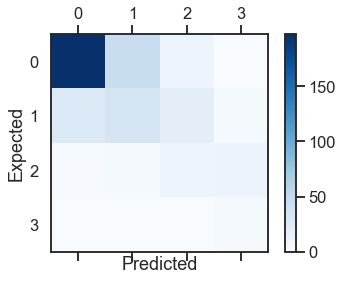

In [693]:
Plot.confusion_matrix(y_test, final_pred)

### f. [Bonus] PCA feature extraction, interpreting PCA components, prediction with RandomForest
#### We want to gain insight in PCA's explained variance and the optimal components for modelling

In [149]:
data.head(3)

,customerid,recency,r_cluster,frequency,f_cluster,revenue,re_cluster,score,m6_revenue,LTV_cluster,segment_High-Value,segment_Low-Value,segment_Mid-Value,segment_VIP
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1,0
1,14560.0,3,3,12,0,562.28,0,3,911.33,0,0,0,1,0
2,16389.0,13,3,16,0,670.17,0,3,692.10,0,0,0,1,0


In [151]:
# Pipeline of pca
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=2))
                ])
pipe.fit(data)

# Output array which explain the variance of each features 
vectors = pipe.steps[1][1].components_.round(2)
print(f'PC 1 effects = {dict(zip(data.columns, vectors[0]))}')

PC 1 effects = {'customerid': -0.02, 'recency': -0.28, 'r_cluster': 0.29, 'frequency': 0.27, 'f_cluster': 0.29, 'revenue': 0.31, 're_cluster': 0.3, 'score': 0.38, 'm6_revenue': 0.27, 'LTV_cluster': 0.27, 'segment_High-Value': 0.25, 'segment_Low-Value': -0.31, 'segment_Mid-Value': 0.2, 'segment_VIP': 0.07}


In [152]:
print(f'PC 1 effects = {dict(zip(data.columns, vectors[1]))}')

PC 1 effects = {'customerid': -0.03, 'recency': 0.36, 'r_cluster': -0.38, 'frequency': 0.19, 'f_cluster': 0.15, 'revenue': 0.25, 're_cluster': 0.23, 'score': -0.12, 'm6_revenue': 0.26, 'LTV_cluster': 0.23, 'segment_High-Value': 0.28, 'segment_Low-Value': 0.32, 'segment_Mid-Value': -0.47, 'segment_VIP': 0.11}


In [153]:
# Explained variance ratio by PCA features
pipe.steps[1][1].explained_variance_ratio_

array([0.44874477, 0.18301891])

PC1 + PC2 = explained %62 variance of information

In [156]:
# Select percentage of information gain by n_components
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=0.85))])

pc = pipe.fit_transform(X_train)
print(f'{len(pipe.steps[1][1].components_)} features were selected with 10% information loss')

3 features were selected with 10% information loss


In [157]:
# The cumsum of each PCA toward 87% 
pipe.steps[1][1].explained_variance_ratio_.cumsum()

array([0.43081581, 0.67984889, 0.87553839])

In [158]:
# Inverse the transformation of PCA
data_rebuilt = pipe.inverse_transform(pc)
data_rebuilt

array([[1.40434510e+04, 7.72818234e+00, 5.02620536e+01, 1.04801945e+03],
       [1.45711873e+04, 6.09483183e+01, 4.85491898e+01, 7.30758314e+02],
       [1.32839228e+04, 1.91222746e+01, 1.37006633e+01, 3.69456653e+02],
       ...,
       [1.52454123e+04, 4.59626291e+01, 2.13971175e+01, 3.19804241e+02],
       [1.62974160e+04, 1.52808176e+01, 4.20159236e+01, 8.13702874e+02],
       [1.60414126e+04, 6.92344653e+01, 6.28820955e+01, 9.03963793e+02]])

In [332]:
# RandomForest modelling with PCA
X = data.drop(['LTV_cluster', 'm6_revenue'], axis=1)
y = data['LTV_cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=3)),
        ('classifier', RandomForestClassifier(random_state=0))])
pipe.fit(X_train, y_train)

print(pipe.steps[1][1].explained_variance_ratio_)
print(f'Accuracy: {pipe.score(X_test, y_test):.2f}')

[0.46095458 0.19656316 0.09057381]
Accuracy: 0.74


In [334]:
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.40181243414120127

we can further explore PCA features by plotting scatter plot. Moreover, the PCA is quite difficult to interprete. At this stage, we can use a combination of method like plotting and compare its components's score